In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

import warnings
warnings.filterwarnings('ignore')


#I. SMS Phishing Detection
##1. Data Loading


In [ ]:
sdf1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/spam.csv", encoding='ISO-8859-1')

sdf1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
sdf1.shape

(5572, 5)

In [ ]:
sdf2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/spam_ham_dataset.csv")

sdf2.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
sdf2.shape

(5171, 4)

In [ ]:
# Keep only the relevant columns and rename them
sdf1 = sdf1[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})


sdf2 = sdf2[['label', 'text']]

In [ ]:
sdf1.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
sdf2.head(5)

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [ ]:
# Combine both datasets into a single DataFrame sdf
sdf = pd.concat([sdf1, sdf2], ignore_index=True)

sdf.sample(5)

,label,text
684,ham,I wanted to ask Ì_ to wait 4 me to finish lect...
6521,ham,"Subject: fw : "" red , white and blue out ""\r\n..."
4549,ham,\Hey! do u fancy meetin me at 4 at cha åÐ hav ...
3431,spam,Camera - You are awarded a SiPix Digital Camer...
6270,ham,Subject: tenaska iv 1 / 01\r\nwe need to chang...


In [ ]:
sdf['label'] = sdf['label'].apply(lambda x: 1 if x == 'spam' else 0)

sdf.sample(5)

,label,text
3342,0,"I haven't forgotten you, i might have a couple..."
6886,1,Subject: family reunion\r\ni know it ' s hard ...
4343,0,Hi:)did you asked to waheeda fathima about leave?
2967,0,"Mostly sports type..lyk footbl,crckt.."
702,0,What is important is that you prevent dehydrat...


##2. Data Cleaning

In [ ]:
sdf.isnull().sum()

,0
label,0
text,0


In [ ]:
sdf = sdf.dropna()
print(sdf.isna().sum())

label    0
text     0
dtype: int64


In [ ]:
sdf.duplicated().sum()

581

In [ ]:
sdf = sdf.drop_duplicates(keep='first')
sdf.duplicated().sum()

0

In [ ]:
sdf.shape

(10162, 2)

In [ ]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10162 entries, 0 to 10742
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10162 non-null  int64 
 1   text    10162 non-null  object
dtypes: int64(1), object(1)
memory usage: 238.2+ KB


##3. EDA

In [ ]:
sms_type_counts = sdf['label'].value_counts()

print(sms_type_counts)

label
0    8047
1    2115
Name: count, dtype: int64


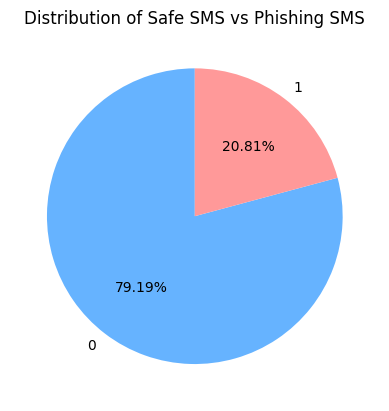

In [ ]:
plt.pie(sms_type_counts, labels=sms_type_counts.index, autopct='%0.2f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Safe SMS vs Phishing SMS')
plt.show()

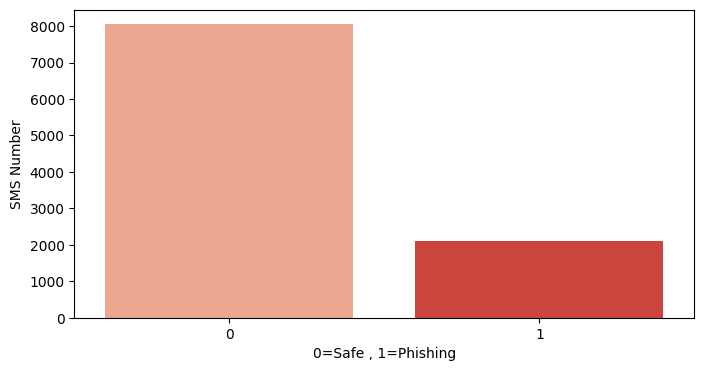

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=sdf, x='label', palette='Reds')
plt.xlabel("0=Safe , 1=Phishing")
plt.ylabel("SMS Number")
plt.show()

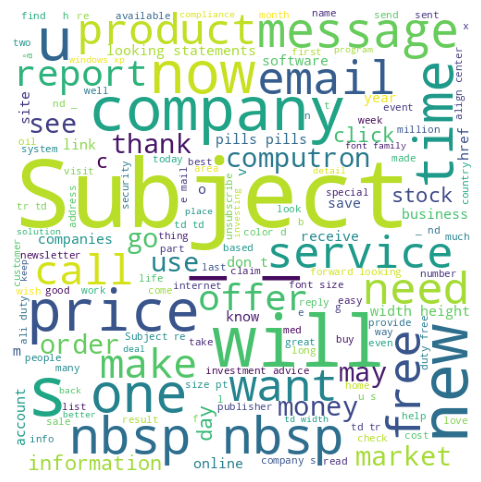

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
phishing_worldcloud = wc.generate(" ".join(sdf[sdf['label'] == 1]['text']))

plt.figure(figsize=(15, 6))
plt.imshow(phishing_worldcloud)
plt.axis('off')
plt.show()

##4.Data Preprocessing

In [ ]:
import string
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

ps = PorterStemmer()

def cleaned_data(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters except letters and numbers
    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Tokenize the cleaned text
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():  # Keep only alphanumeric tokens
            y.append(i)

    text = y[:]
    y.clear()

    # Remove stopwords and punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
cleaned_text = cleaned_data("Hello! Visit https://example.com for 50% OFF on your purchase!!! Don't miss out. Call us NOW at 123-456-7890 or email at sales@example.com.")
print(cleaned_text)

hello visit exampl com 50 purchas miss call us 123 456 7890 email sale exampl com


In [ ]:
sdf['cleaned_text'] = sdf['text'].apply(cleaned_data)

In [ ]:
sdf.sample(5)

,label,text,cleaned_text
4890,0,Its worse if if uses half way then stops. Its ...,wors use half way stop better complet
10182,0,Subject: order confirmation from footlocker . ...,subject order confirm footlock com dear daren ...
6432,0,"Subject: re : meter 1459 , 6 / 00\r\nyep , you...",subject meter 1459 6 00 yep right except june ...
7230,0,Subject: re : big cowboy / gepl actuals for fe...,subject big cowboy gepl actual februari pleas ...
2249,1,"Thanks for your ringtone order, ref number R83...",thank rington order ref number r836 mobil char...


In [ ]:
sdf = sdf[['label', 'cleaned_text']]
sdf.sample(5)

,label,cleaned_text
808,0,take half day leav bec well
3545,0,th gower mate r u man good wale ill b back mor...
5503,0,perhap much easi give account identif tomorrow...
4205,0,get door
7617,0,subject organiz chang make number signific org...


In [ ]:
sdf = sdf.drop_duplicates(keep='first')
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 10742
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         9989 non-null   int64 
 1   cleaned_text  9989 non-null   object
dtypes: int64(1), object(1)
memory usage: 234.1+ KB


In [ ]:
sdf.sample(5)

,label,cleaned_text
5716,1,subject penl enlarg 3 ment plll
6022,1,subject free sport event pay movi border lpx s...
2683,0,okay chase dream good next
8820,0,subject februari issu current go februari setu...
10092,0,subject may wellhead spot purchas request vanc...


In [ ]:
# now counting the top words used in smishing
from collections import Counter
phishing = []
for msg in sdf[sdf['label'] == 1]['cleaned_text'].tolist():
    for word in msg.split():
        phishing.append(word)

Counter(phishing).most_common(10)

[('subject', 1618),
 ('3', 1258),
 ('com', 1036),
 ('2', 1028),
 ('http', 1000),
 ('compani', 921),
 ('1', 792),
 ('price', 745),
 ('0', 682),
 ('www', 665)]

##5.Feature Etraction

In [ ]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=5000)

In [ ]:
sdf = sdf.dropna(subset=['cleaned_text'])
X = tfidf.fit_transform(sdf['cleaned_text']).toarray()
X.shape

(9989, 5000)

In [ ]:
print("Total features:", len(tfidf.get_feature_names_out()))

Total features: 5000


In [ ]:
non_zero_indices = np.nonzero(X[0])[0]  # non-zero indices for the document
non_zero_words = tfidf.get_feature_names_out()[non_zero_indices]  # corresponding words
non_zero_tfidf_scores = X[0, non_zero_indices]  # TF-IDF scores for non-zero words


for word, score in zip(non_zero_words, non_zero_tfidf_scores):
    print(f"Word: {word}, TF-IDF Score: {score}")

Word: amor, TF-IDF Score: 0.4957742344761679
Word: avail, TF-IDF Score: 0.24402683569030387
Word: crazi, TF-IDF Score: 0.40073100353120233
Word: go, TF-IDF Score: 0.19501413330056974
Word: got, TF-IDF Score: 0.2471844053064956
Word: great, TF-IDF Score: 0.26129825658480105
Word: la, TF-IDF Score: 0.3373972970559402
Word: point, TF-IDF Score: 0.26090474772581745
Word: wat, TF-IDF Score: 0.320812763892794
Word: world, TF-IDF Score: 0.2860716701639775


In [ ]:
y = sdf['label'].values

##6.Model Training

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

(7991, 5000) (1998, 5000)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score

# Khởi tạo mô hình Naive Bayes (Multinomial Naive Bayes) với tham số mặc định
nb = MultinomialNB()

# Huấn luyện mô hình
nb.fit(X_train, y_train)

# Dự đoán từ mô hình đã huấn luyện
y_pred = nb.predict(X_test)

# Đánh giá mô hình
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.9594594594594594
Confusion Matrix:
 [[1570   17]
 [  64  347]]
Precision (weighted): 0.9592821953593066
F1 Score (weighted): 0.9585259441973947


In [ ]:
from joblib import dump
import os

# Đảm bảo đường dẫn tới thư mục là chính xác
drive_path = '/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset'

# Lưu vectorizer (tfidf) và mô hình (rf)
dump(tfidf, os.path.join(drive_path, 'vectorizer_ NaiveBayes.pkl'))
dump(nb, os.path.join(drive_path, 'model_ NaiveBayes.pkl'))


['/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/model_ NaiveBayes.pkl']

##7.Inference

In [ ]:
from joblib import load
import numpy as np

loaded_model = load("/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/model_ NaiveBayes.pkl")
loaded_vectorizer = load("/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/vectorizer_ NaiveBayes.pkl")

# Example input
input_messages = np.array([
    "Congratulations! You've been selected for a free vacation to the Bahamas. Click to claim your prize.",
    "Please check the attached report for the meeting tomorrow.",
    "Free entry into our contest to win a brand new car! Click here now.",
    "Meeting scheduled for 10 AM. Don’t forget the necessary documents.",
])

# Vectorize the input messages using the loaded vectorizer

vectorized_messages = loaded_vectorizer.transform(input_messages)
print(vectorized_messages.shape)
predictions = loaded_model.predict(vectorized_messages)
print(predictions)

(4, 5000)
[1 0 1 0]
